# 0.0. IMPORTS

In [90]:
# import the relevant libraries
import math
import inflection
import numpy as np
import pandas as pd
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set()

from scipy           import stats
from datetime        import datetime
from datetime        import timedelta
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
# chi2 formula
def cramer_v( x, y ):
    # calculate confusion matrix (cm), contingency table
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    # calculate chi2
    chi2 = stats.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return Cramer V
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
# both files share the same 'Store' column, therefore on='Store'
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# Note on pd.read_csv low_memory (from pandas website):
# Internally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference. 
# To ensure no mixed types either set False, or specify the type with the dtype parameter. 
# Note that the entire file is read into a single DataFrame regardless, use the chunksize or iterator parameter to return 
# the data in chunks. (Only valid with C parser).

In [4]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
414160,166,3,2014-06-25,4083,648,1,0,0,0,a,c,100.0,4.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
908626,687,1,2013-04-08,10082,834,1,1,0,0,d,c,2770.0,NaN,NaN,0,NaN,NaN,NaN
948434,355,7,2013-03-03,0,0,0,0,0,0,a,c,9720.0,8.0,2013.0,0,NaN,NaN,NaN
486531,62,1,2014-04-21,0,0,0,0,b,1,a,a,2050.0,NaN,NaN,0,NaN,NaN,NaN
488932,233,6,2014-04-19,9782,1162,1,0,0,1,a,a,1890.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. STEP 01 - DATA DESCRIPTION

In [5]:
# copy original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [9]:
df1['date'].describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: date, dtype: object

In [10]:
df1[['competition_open_since_year', 'promo2_since_year']].describe()

,competition_open_since_year,promo2_since_year
count,693861.000000,509178.000000
mean,2008.690228,2011.752774
std,5.992644,1.662870
min,1900.000000,2009.000000
25%,2006.000000,2011.000000
50%,2010.000000,2012.000000
75%,2013.000000,2013.000000
max,2015.000000,2015.000000


In [11]:
df1['store'].value_counts()

1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: store, Length: 1115, dtype: int64

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
411382,733,6,2014-06-28,15219,3508,1,0,0,0,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN


In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
# Same assumption as promo2_since_week
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
# Dictionary for Months
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

# Add new column with month information
df1['month_map'] = df1['date'].dt.month.map(month_map)

# New column that shows if at that date the store was in promo2.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
# compare promo2 and promo_interval
df1['compare'] = df1[['promo2', 'promo_interval']].apply(lambda x: 1 if x['promo2'] == 1 and x['promo_interval'] !=0 else 0, axis=1)
df1['compare'].value_counts()

1    509178
0    508031
Name: compare, dtype: int64

In [17]:
df1['promo_interval'].value_counts()

0                   508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: promo_interval, dtype: int64

In [18]:
df1['promo_interval'].dtype

dtype('O')

In [19]:
df1['month_map'].value_counts()

Mar    103695
May    103695
Jan    103694
Jun    100350
Apr    100350
Jul     98115
Feb     93660
Aug     63550
Dec     63550
Oct     63550
Nov     61500
Sep     61500
Name: month_map, dtype: int64

In [20]:
df1['month_map'].dtype

dtype('O')

In [21]:
df1['promo2'].dtype

dtype('int64')

In [22]:
df1['promo2'].value_counts()

1    509178
0    508031
Name: promo2, dtype: int64

In [23]:
df1['promo2'].sum()

509178

In [24]:
df1['is_promo'].sum()

168822

In [25]:
df1['is_promo'].value_counts()

0    848387
1    168822
Name: is_promo, dtype: int64

**Remarks:**
coluna promo2 é equivalente ao valor de entradas do promo_interval.

coluna is_promo não corresponde ao valor de entradas do promo_interval (mas deveria).

In [26]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
compare                         0
dtype: int64

# 2.0. STEP 02 - FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

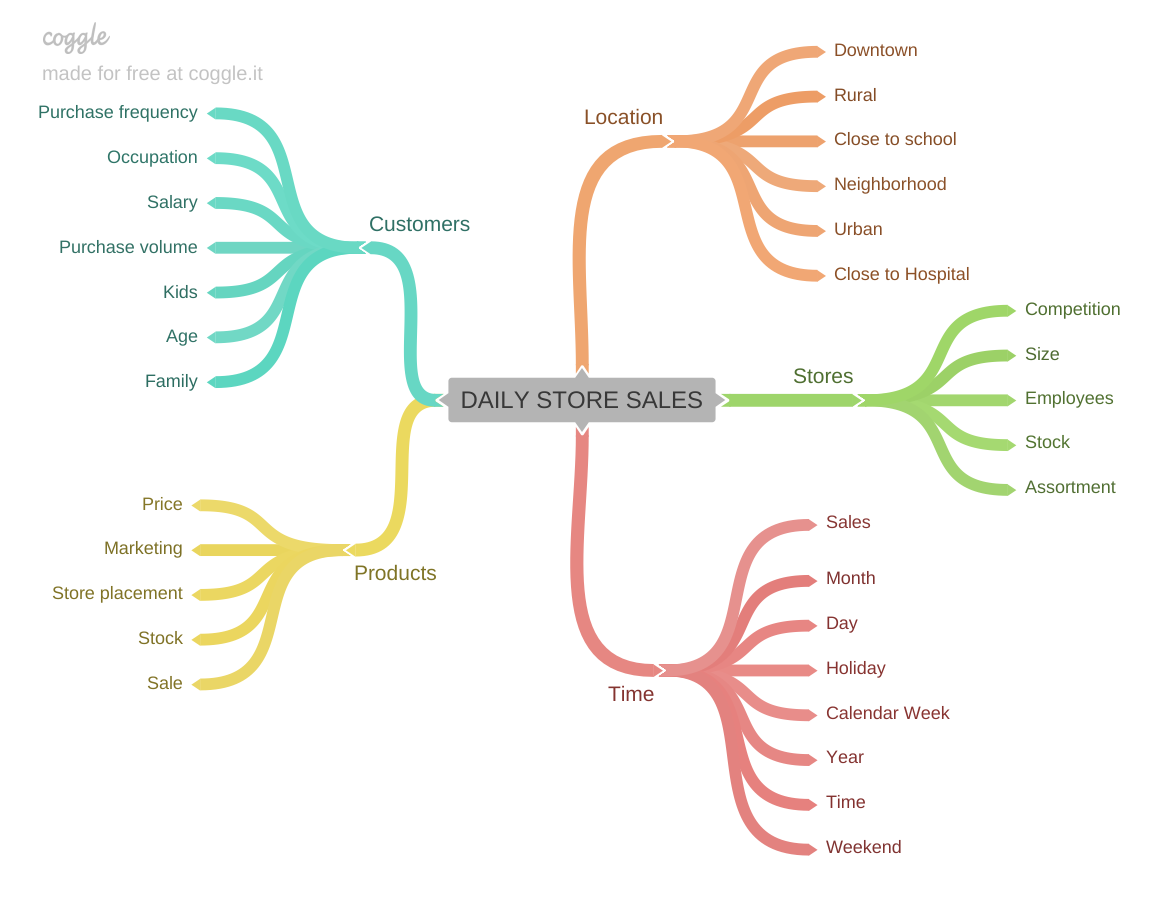

In [28]:
Image('img/Mindmaphypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with bigger staff (employees) should sell more.

**2.** Stores with bigger Stock should sell more.

**3.** Stores with bigger size should sell more.

**4.** Stores with bigger Assortment should sell more.

**5.** Stores with competition closer should sell less.

**6.** Stores with longer time competition should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more on Marketing should sell more.

**2.** Stores that expose more the products (Store Placement) should sell more.

**3.** Stores with lower product prices should sell more.

**4.** Stores with more agressive Sale (bigger discount) should sell more.

**5.** Stores with longer Sale (promo) should sell more.

**6.** Stores with more Sale (promo) days should sell more.

**7.** Stores with more consecutive Sale (promo) should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open on Christmas time should sell more.

**2.** Stores should sell more throughout the years.

**3.** Stores should sell more on second semester.

**4.** Stores should sell more after the 10th months day.

**5.** Stores should sell less on weekend.

**6.** Stores should sell less while school vacation.

## 2.3. Final Hypothesis List (Based on the data available in the original dataset)

**1.** Stores with bigger Assortment should sell more.

**2.** Stores with competition closer should sell less.

**3.** Stores with longer time competition should sell more.

**4.** Stores with longer Sale (promo) should sell more.

**5.** Stores with more Sale (promo) days should sell more.

**6.** Stores with more consecutive Sale (promo) should sell more.

**7.** Stores open on Christmas time should sell more.

**8.** Stores should sell more throughout the years.

**9.** Stores should sell more on second semester.

**10.** Stores should sell more after the 10th months day.

**11.** Stores should sell less on weekend.

**12.** Stores should sell less while school vacation.

## 2.4. Feature Engineering

In [29]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
compare                                  int64
dtype: object

In [30]:
# convert float64 to int64
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype('int64')
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype('int64')
df2['promo2_since_week'] = df2['promo2_since_week'].astype('int64')
df2['promo2_since_year'] = df2['promo2_since_year'].astype('int64')

In [31]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1 in order to consider the full month.
df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [32]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - VARIABLES FILTERING

In [33]:
df3 = df2.copy()

In [34]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,compare,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Line Filtering

In [35]:
# closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
# sales = 0 will also be removed.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [36]:
# Customers is a variable that is not available at the time of prediction, hence it is a business restriction.
# To use Customers variable, a new project is needed only for customers forecast in the next 6 weeks, and then use it as input in this sales forecast project.
# Therefore, the column customers must be removed.
# open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
# promo_interval generated new columns in the feature engineering step and is no longer needed.
# month_map is an auxiliary column and hence will be removed.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'compare', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [38]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

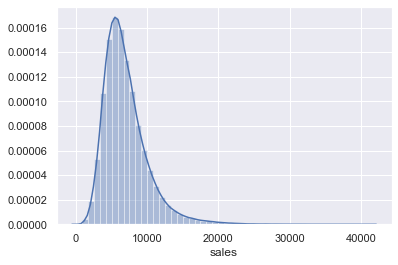

In [39]:
sns.distplot( df4['sales'] )

In [40]:
df4['sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: sales, dtype: float64

### 4.1.2. Numerical Variable

In [41]:
# select numerical columns
numeric_cols = [cname for cname in df4.columns if df4[cname].dtype in ['int64', 'float64']]
num_attributes = df4[numeric_cols]

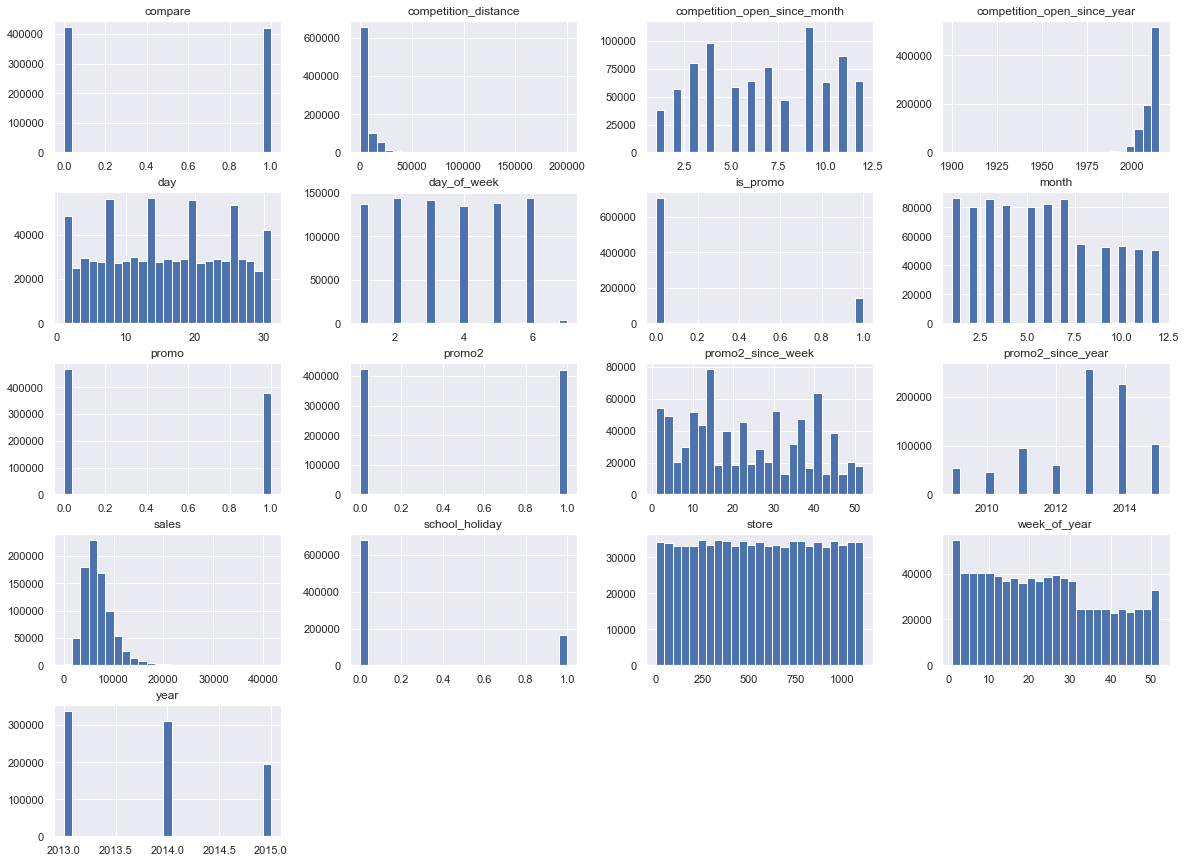

In [42]:
# generate histogram for all numerical variables
num_attributes.hist( bins=25, figsize=(20,15) );

### 4.1.3. Categorical Variable

In [43]:
# select categorial columns
categorical_cols = [cname for cname in df4.columns if df4[cname].dtype == "object"]
cat_attributes = df4[categorical_cols]

In [44]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


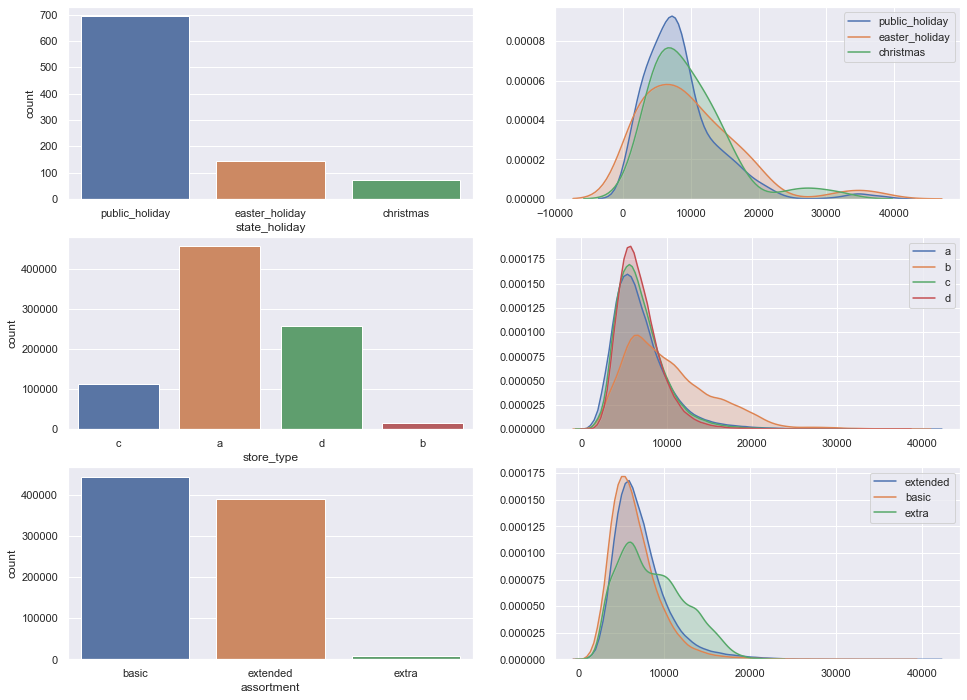

In [45]:
# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(16, 12))

# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Bivariate Analysis

### H1. Stores with bigger Assortment should sell more.
**FALSE** Stores with BIGGER ASSORTMENT sell LESS.

Comentários:
O resultado da análise é um insight pois as lojas com maior sortimento vendem menos, ou seja, é contraintuitivo.

A variável assortment explica dois tipos de comportamento, portanto pode ser relevante para o modelo. Relevância baixa.

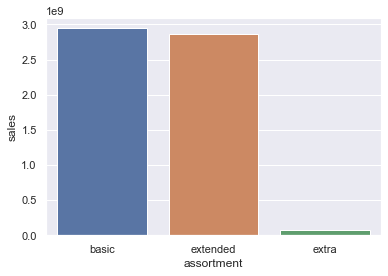

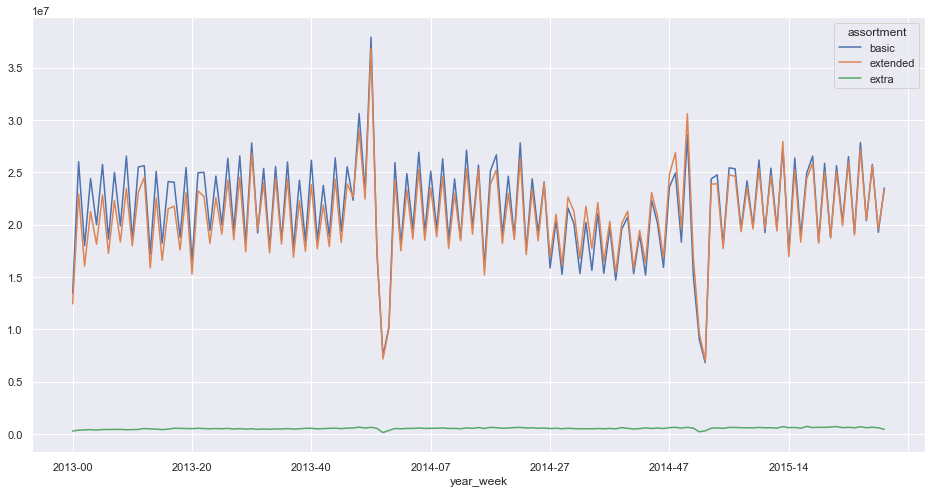

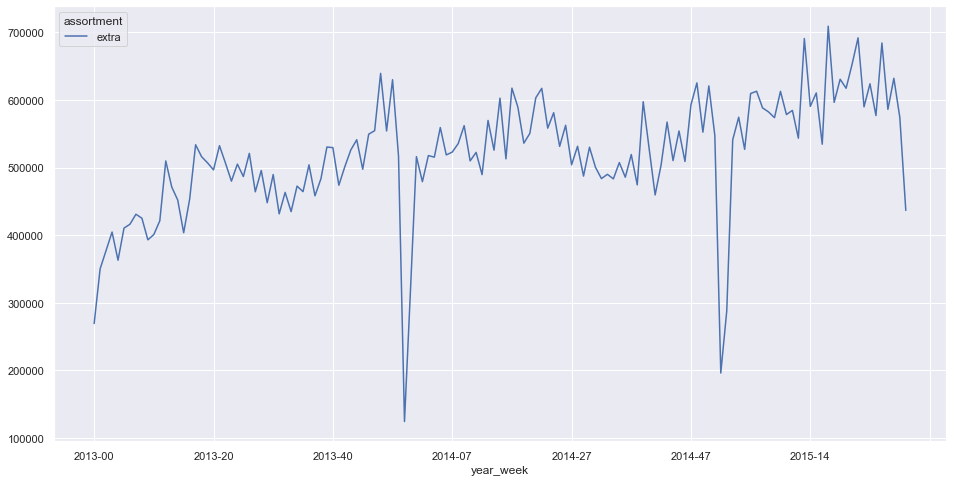

In [46]:
# plot the sum of sales by assortment.
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

# sum of all sales by assortment and by year_week.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()

# pivot for year_week as line (index), assortment types as columns and sales as values.
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()
aux3.plot(figsize=(16,8))

# plot the assortment type 'extra' in order to check its behaviour.
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(16,8))

# Assumption based on the available data description: big assortment = 'extra'.
# After the graphs analysis we can conclude that big assortment (extra) does not sell more than the other ones.
# Therefore we can claim that the Hypothesis H1 is not valid (false).

In [47]:
# sum of all sales by assortment and by year_week.
# remember: aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [48]:
# aux3 contains the pivot made above for year_week as line (index), assortment types as columns and sales as values.
# remember: aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


### H2. Stores with competition closer should sell less.
**FALSE** Stores with COMPETITION CLOSE sell MORE.

Comentários:
O resultado da análise é um insight pois as lojas com a concorrência mais próxima vendem mais, ou seja, é totalmente contra o senso comum.

A correlação do método de pearson varia de -1 a 1, sendo que em 1 as variáveis são perfeitamente correlacionadas positivamente e -1 elas tem uma correlação negativa.
O valor de -0,23 indica uma correlação fraca. Pode ser relevante para o modelo, mas de uma maneira mais fraca. Relevância média.

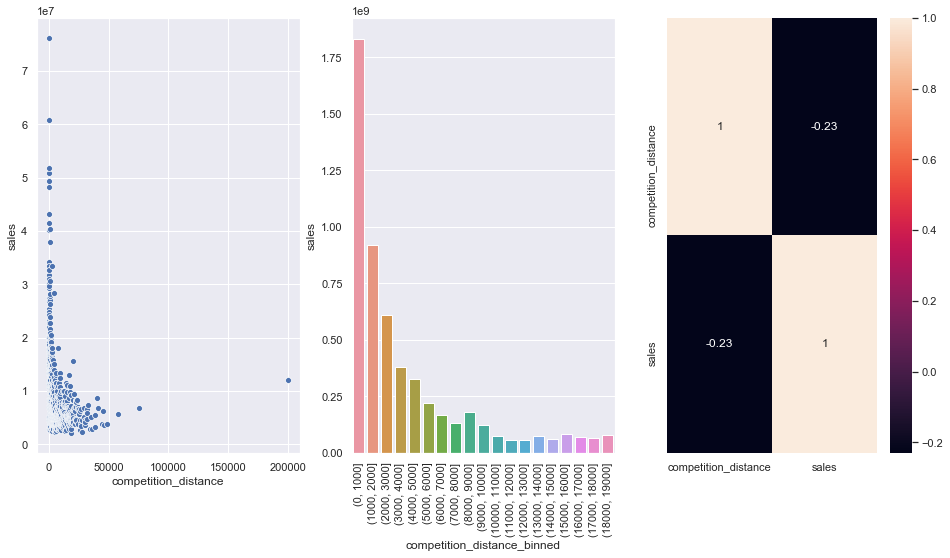

In [49]:
# sum of sales by competition_distance
aux2_1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1 )
# scatter plot competition_distance and sales (aux2_1)
sns.scatterplot( x='competition_distance', y='sales', data=aux2_1)

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2 )
# create bins to group the values for better plot visualization
bins = list( np.arange( 0, 20000, 1000 ) )
# arrange the values to each corresponding group (bins) 
# and store it in the new column 'competition_distance_binned'.
aux2_1['competition_distance_binned'] = pd.cut( aux2_1['competition_distance'], bins=bins )
# sum of sales by competition_distance_binned
aux2_2 = aux2_1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
# plot sum of sales by competition_distance_binned
sns.barplot( x='competition_distance_binned', y='sales', data=aux2_2 );
# axis rotation
plt.xticks( rotation=90 )

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3 )
# correlation weight between competition_distance and sales
sns.heatmap( aux2_1.corr( method='pearson' ), annot=True );

In [50]:
aux2_1.sample(4)

,competition_distance,sales,competition_distance_binned
529,13750.0,5072945,"(13000, 14000]"
209,2440.0,5856384,"(2000, 3000]"
478,9770.0,2626269,"(9000, 10000]"
316,4300.0,3960984,"(4000, 5000]"


### H3. Stores with longer time competition should sell more.
**FALSE** Stores with LONGER TIME COMPETITION sell LESS.

Comentários:
O resultado da análise é um insight pois lojas com mais tempo de concorrência vendem menos, ou seja, é contraintuitivo.

Correlação entre o tempo que os competidores começaram e as vendas. Relação de pearson de 0,1. Relevância média.

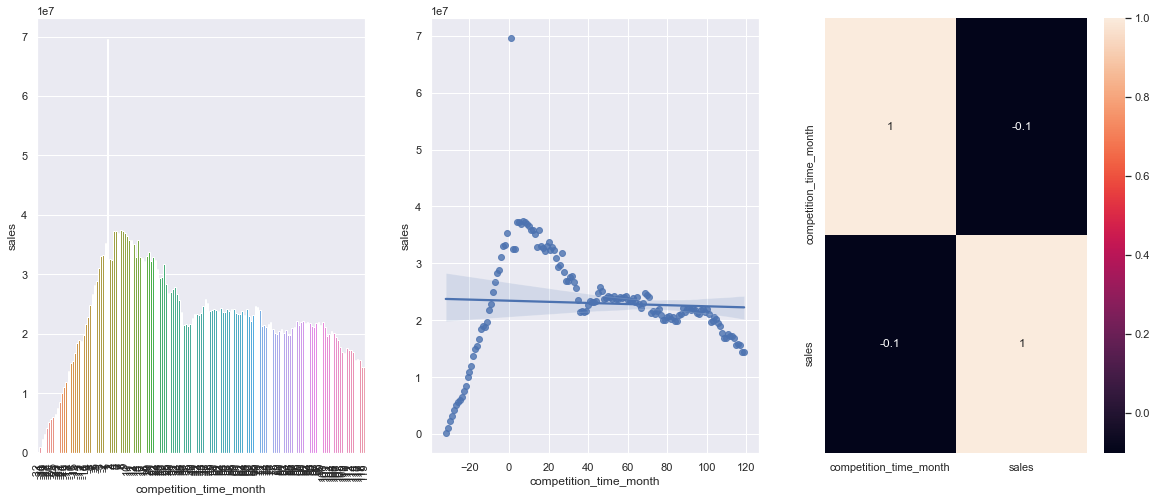

In [51]:
# sum of sales by competition_time_month
aux3_1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()

# Filter values lower than 120 in order to check the first 120 months of competition
# Filter competition time == 0 (competition open in the same month of the sale)
aux3_2 = aux3_1[(aux3_1['competition_time_month'] < 120) & ( aux3_1['competition_time_month'] != 0 )]

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1)
# bar plot
sns.barplot( x='competition_time_month', y='sales', data=aux3_2)
# rotate x axis labels
plt.xticks( rotation=90 );

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2)
# plot regplot
sns.regplot( x='competition_time_month', y='sales', data=aux3_2);

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3)
sns.heatmap( aux3_1.corr(method='pearson'), annot=True)

# competition time month negative values mean that the competition will open a new store soon in the future.
# the bar plot shows that competition time month values near to zero represents more sales than bigger competition time month.

### **H4.** Stores with longer Sale (promo) should sell more.
**FALSE** Stores with longer Sale (promo) sell less after some promo period.

Comentários:
O resultado da análise pode ser um insight pois as lojas com mais tempo de promoção vendem menos, ou seja, é contrário ao que normalmente se acredita.

Relação de pearson: 0,029. Provavelmente será uma variável não relevante para o modelo. Relevância baixa.

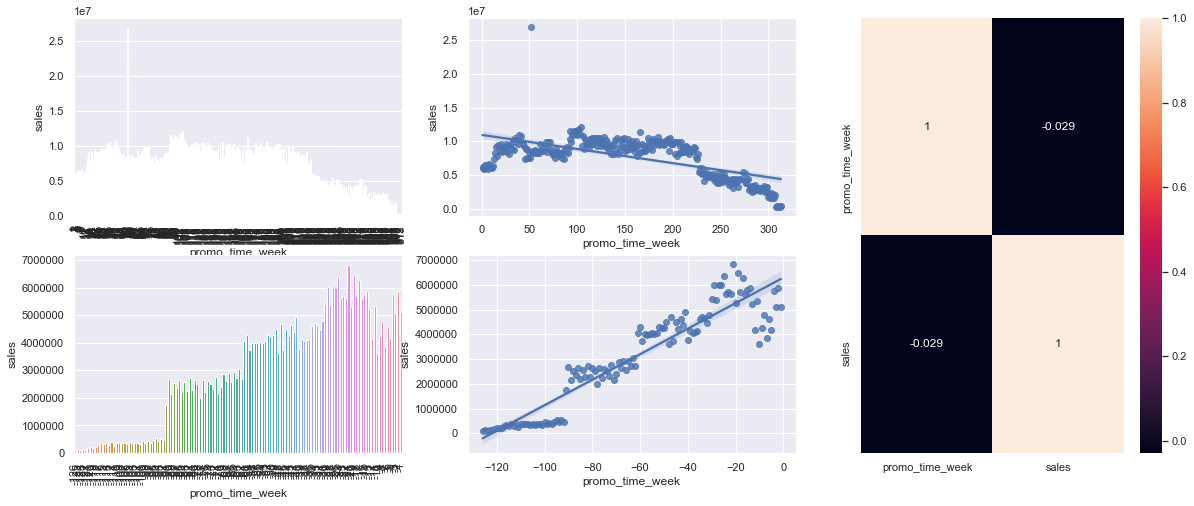

In [52]:
# two periods of promo: the standard (promo) and the extended (promo 2).
# promo_time_week > 0 means the sale at that date was done in the promo 2 period (extended).
# promo_time_week < 0 means the sale at that date was done in the standard promo period.

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# Grid spec - plot
grid = gridspec.GridSpec( 2, 3)

# sum of sales by promo_time_week
aux4_1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# sort the data into extended promo period (promo2).
plt.subplot( grid[0,0] )
aux4_2 = aux4_1[aux4_1['promo_time_week'] > 0] # promo extended (promo 2)
# bar plot
sns.barplot( x='promo_time_week', y='sales', data=aux4_2 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux4_2 );

# sort the data into standard promo period.
plt.subplot( grid[1,0] )
aux4_3 = aux4_1[aux4_1['promo_time_week'] < 0] # promo standard
# bar plot
sns.barplot( x='promo_time_week', y='sales', data=aux4_3 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux4_3 );

# Correlation strength - heatmap
plt.subplot( grid[:,2] )
sns.heatmap( aux4_1.corr( method='pearson'), annot=True );

### <s>**H5.** Stores with more Sale (promo) days should sell more.</s>

Hypothesis H5 (more sale days) is very similar to hypothesis H4 (longer sale promo). To validate hypothesis H5 we should create a new feature called promo days. The validation of this hypothesis can be done in the second CRISP cycle. Therefore, at this time it will be placed on hold.

### **H6.** Stores with more consecutive Sale (promo) should sell more.
**FALSE** Stores with more consecutive Sale sell less.

Comentários:
O resultado da análise pode ser um insight pois a análise demonstra que lojas com mais promoções consecutivas vendem menos, ou seja, contrário ao senso comum de que mais promoções representam mais vendas.

Comportamento similar das vendas durante ambos os períodos de promoção tradicional e de promoção tradicional e extendida (promo2), exceto pelo período da semana 26 de 2014 até aproximadamente as últimas semanas de 2014. Relevância baixa.

In [53]:
# sum of sales by promo and promo2.
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


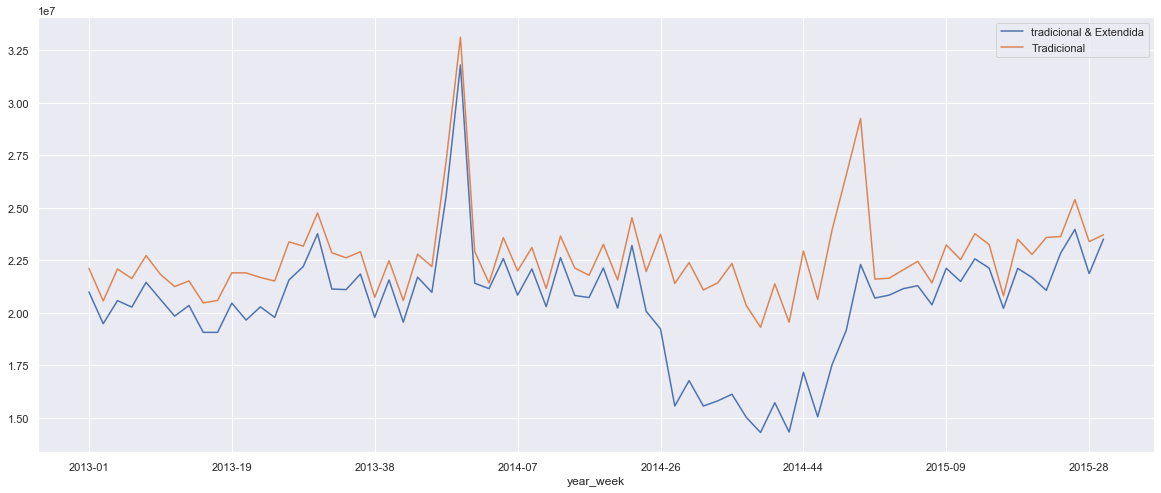

In [54]:
# Check stores sales in by year_week (sales in time) with respect to promo and promo2
aux6_1 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux6_1 = aux6_1.set_index('year_week')
ax = aux6_1.plot( figsize=(20,8))

# Only stores with promo
aux6_2 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()

aux6_2.plot( ax=ax)

ax.legend( labels=['tradicional & Extendida', 'Tradicional'])

In [55]:
aux6_1.head()

,sales
year_week,
2013-01,20995409
2013-03,19481514
2013-05,20580811
2013-07,20273185
2013-09,21451952


### **H7.** Stores open on Christmas time should sell more.
**False** Stores open on Christmas sell less.

Comentários:
Esta análise não representa um insight pois a informação de que as vendas no período do natal são menores já são normalmente de conhecimento do time de negócios.

Será uma variável relevante para o modelo, pois as vendas nos feriados cresceram de 2013 para 2014 e diminuiram de 2014 para 2015. Relevância média.

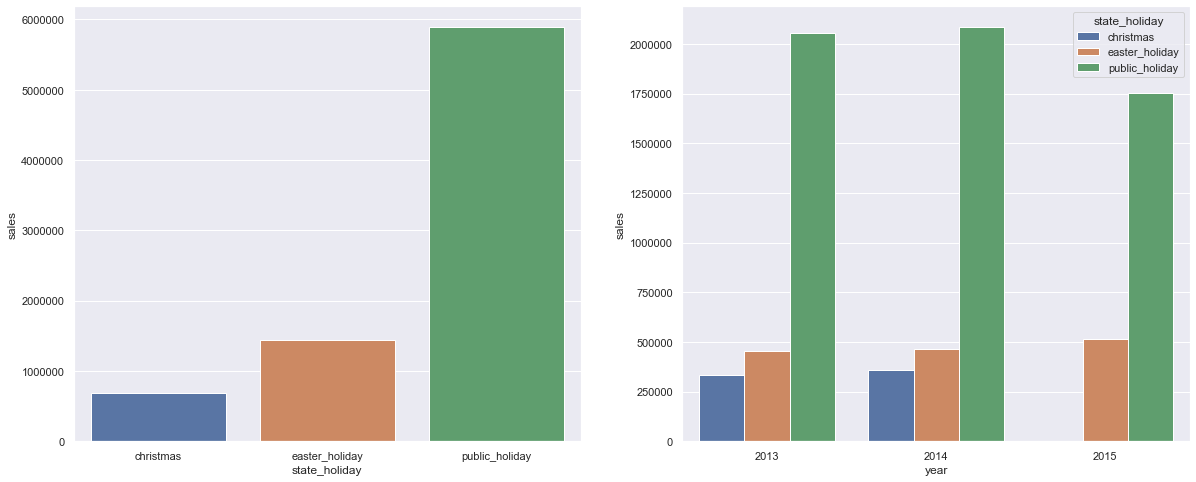

In [56]:
# filter state_holiday without 'regular_day'
aux = df4[df4['state_holiday'] != 'regular_day']

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 2, 1)
# sum of sales by state_holiday
aux7_1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux7_1);


# set up subplot
plt.subplot( 1, 2, 2)
# sum of sales by state_holiday and year
aux7_2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux7_2)

### **H8.** Stores should sell more throughout the years.
**FALSE** Stores sell less throughout the years.

Comentários:
Esta análise não representa um insight pois os analistas de negócios acompanham a métrica de vendas por ano. A análise mostra uma queda nas vendas de 2013 a 2015, o que pode ser um sinal de alerta para o negócio. Obs: o ano de 2015 ainda não está fechado no dataset, ou seja, é um valor que tende a crescer até o final daquele ano.

Correlação de pearson alto, relevante para o modelo. Relevância alta.

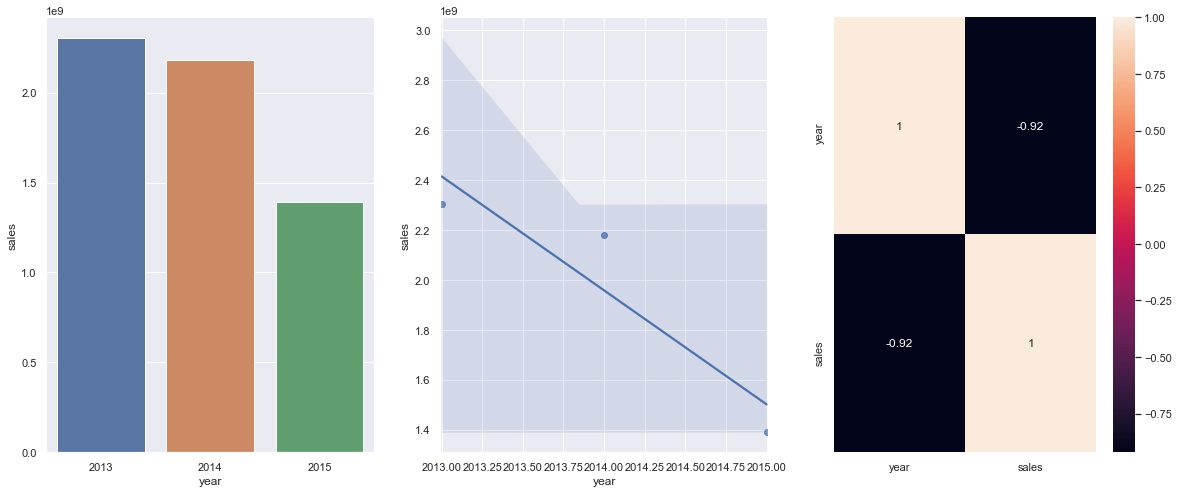

In [57]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by year
aux8_1 = df4[['year', 'sales']].groupby( 'year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux8_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='year', y='sales', data=aux8_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux8_1.corr( method='pearson'), annot=True);

### **H9.** Stores should sell more on second semester.
**FALSE** Stores sell less on second semester.

Comentários:
Esta análise não gera um insight pois depende muito do negócio.

Correlação de pearson relevante: -0,75 (enquanto o número do mês sobe, as vendas descem). Relevância alta.

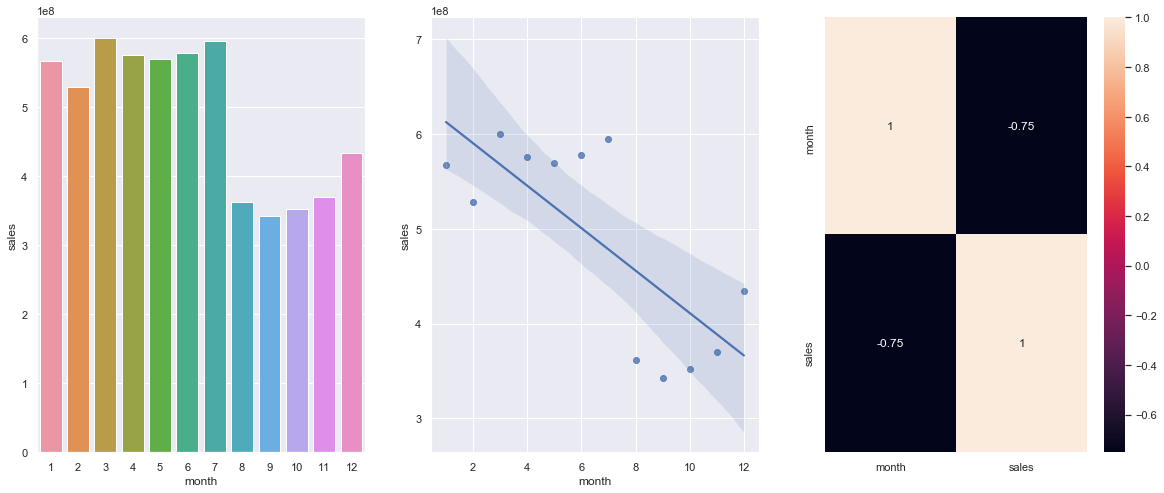

In [58]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by month
aux9_1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux9_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='month', y='sales', data=aux9_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux9_1.corr( method='pearson'), annot=True);

### **H10.** Stores should sell more after the 10th day of the month.
**TRUE** Stores sell more after the 10th day of the month.

Comentários:
Esta análise não é uym insight pois os analistas de negócios acompanham este tipo de métrica.

A variável pode ser relevante para o modelo. Relevância alta.

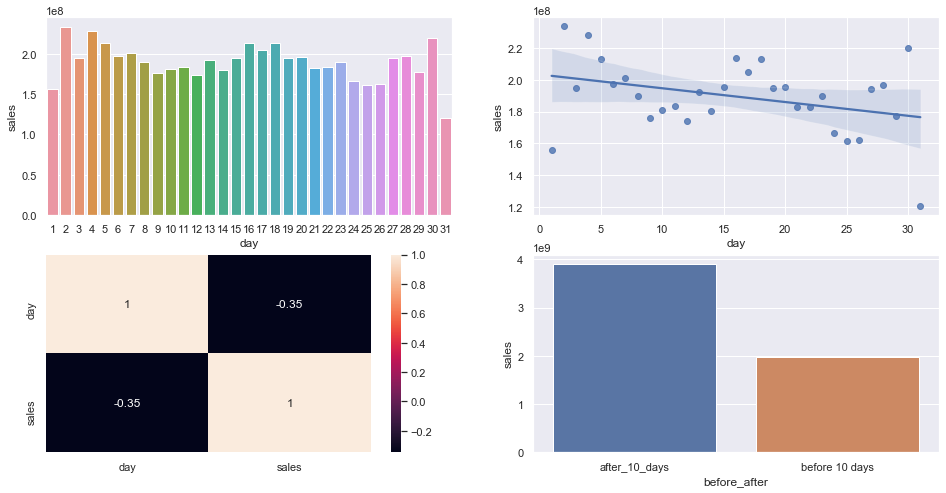

In [59]:
# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# set up subplot
plt.subplot( 2, 2, 1)
# sum of sales by day
aux10_1 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux10_1 );

# set up subplot
plt.subplot( 2, 2, 2)
# Trend graph
sns.regplot( x='day', y='sales', data=aux10_1);

# set up subplot
plt.subplot( 2, 2, 3)
# correlation graph (heatmap)
sns.heatmap( aux10_1.corr( method='pearson'), annot=True);

# set up subplot
plt.subplot( 2, 2, 4)
# filter the days before and after the 10th day of each month
aux10_1['before_after'] = aux10_1['day'].apply( lambda x: 'before 10 days' if x <= 10 else 'after_10_days')
aux10_2 = aux10_1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux10_2)

### **H11.** Stores should sell less on weekend.
**TRUE** Stores sell less on weekend.

Comentários:
Esta análise não deve gerar um insight pois os analistas de negócios acompanham este tipo de métrica.

Correlação de pearson de -0,76 (forte) relevante para o modelo. Relevância alta.

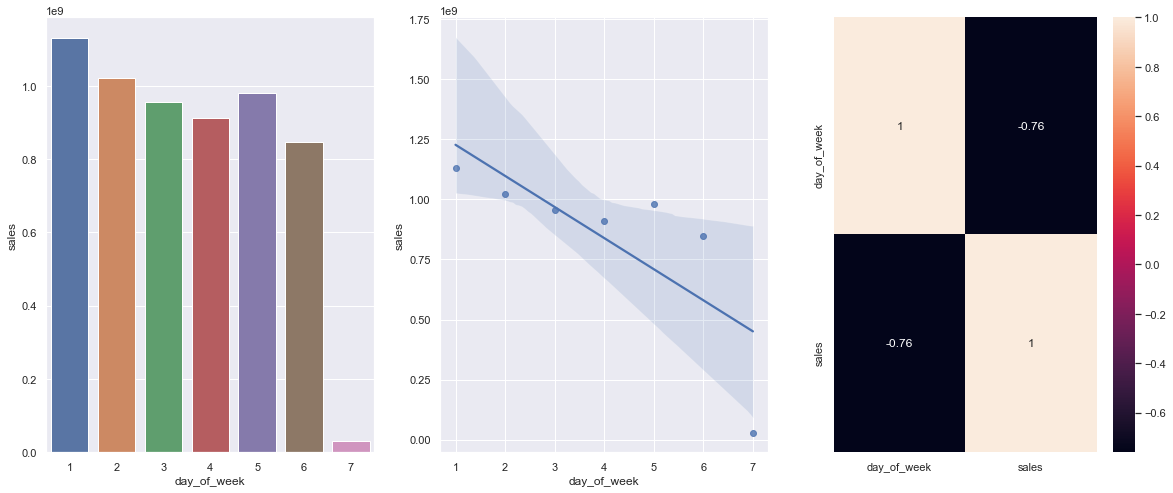

In [60]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by day_of_week
aux11_1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux11_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='day_of_week', y='sales', data=aux11_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux11_1.corr( method='pearson'), annot=True);

### **H12.** Stores should sell less while school vacation.
**TRUE** Stores sell less during school vacation, except in July and August.

Comentários:
Esta análise não deve gerar um insight pois os analistas de negócios acompanham este tipo de métrica.

Variável relevante para o modelo pois nos meses 7 (aprox.) e 8 as vendas durante as férias escolares são maiores do que nos dias comuns.

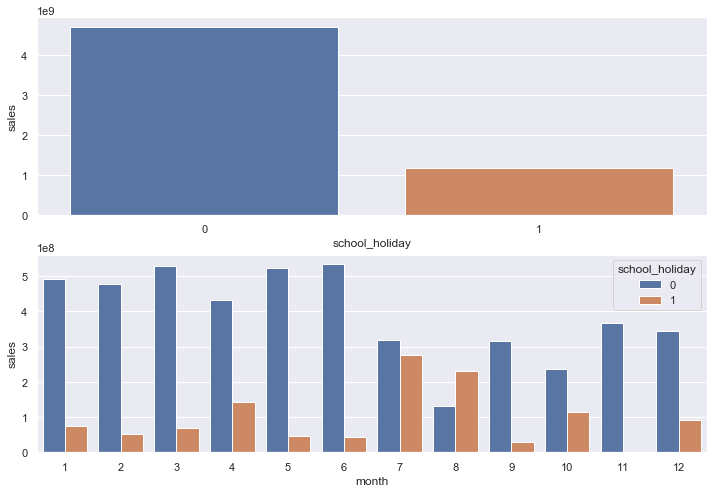

In [61]:
# set up figure size
f, ax = plt.subplots(figsize=(12,8))

# set up subplot
plt.subplot( 2, 1, 1)
# sum of sales by school_holiday
aux12_1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux12_1);

# set up subplot
plt.subplot( 2, 1, 2)
aux12_2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux12_2);

### 4.2.1. Hypothesis Summary

In [62]:
from tabulate import tabulate

In [63]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low'],      
      ]

print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

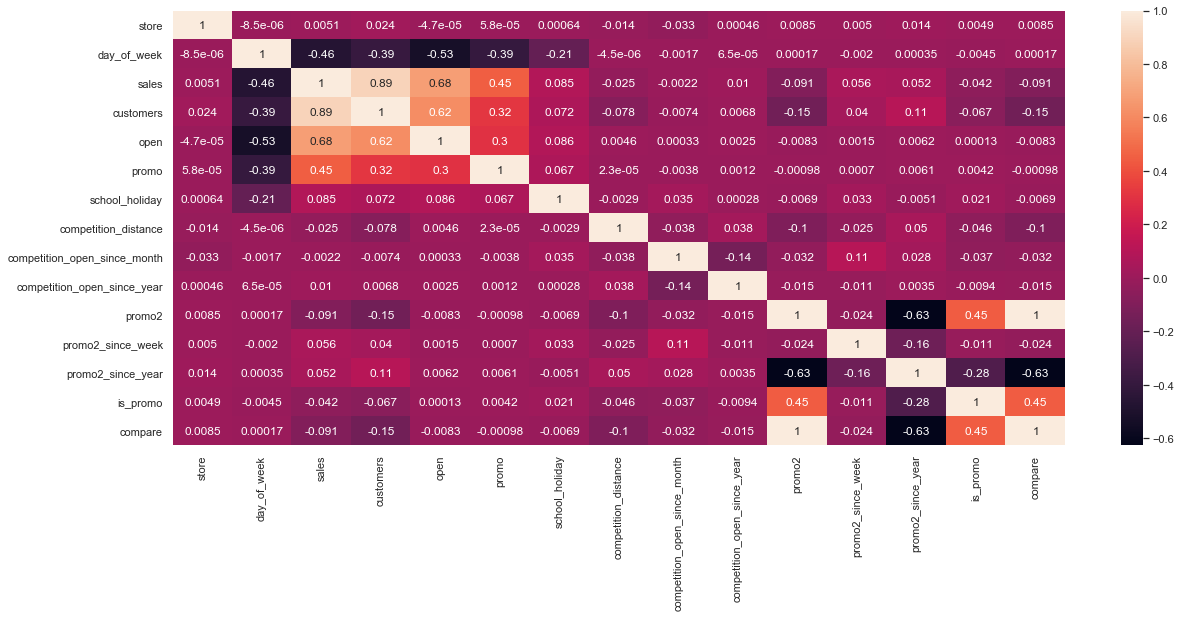

In [64]:
# select numerical columns from the df1
numeric_cols = [cname for cname in df1.columns if df1[cname].dtype in ['int64', 'float64']]
num_attributes = df1[numeric_cols]

# correlation by pearosn method
correlation = num_attributes.corr( method='pearson' )

# set up figure size
f, ax = plt.subplots( figsize=(20,8))

sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [68]:
# Select categorical attributes
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [66]:
# confusion matrix makes all the possible combinations between categorical variables
# and count the number of lines of that combination.
a[(a['state_holiday'] == 'christmas' ) & ( a['store_type'] == 'a' )]

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,compare,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
241499,530,5,2014-12-26,4601,0,christmas,1,a,extended,18160.0,...,0,2014,12,26,52,2014-51,2014-12-01,0,2014-12-22,0
241977,1099,5,2014-12-26,3719,0,christmas,1,a,extended,200.0,...,1,2014,12,26,52,2014-51,2013-04-01,21,2013-04-01,90
616339,530,4,2013-12-26,4712,0,christmas,1,a,extended,18160.0,...,0,2013,12,26,52,2013-51,2013-12-01,0,2013-12-23,0
616908,1099,4,2013-12-26,3929,0,christmas,1,a,extended,200.0,...,1,2013,12,26,52,2013-51,2013-04-01,8,2013-04-01,38


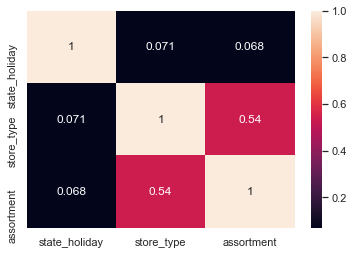

In [67]:
# calculate Cramer V
# Cramer V (chi2) formula is in the 0.1. Helper Functions subsection.
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9] })

d = d.set_index( d.columns)

sns.heatmap( d, annot=True)

# 5.0. STEP 05 - DATA PREPARATION

In [70]:
# Copy the previous dataframe. Remove auxiliary column 'compare'.
df5 = df4.copy()
df5 = df5.drop('compare', axis=1)

## 5.1. Standardization

Remark: None of the numerical variables have a normal distribution (see subsection 4.1.2.), therefore the Standardization will not be applied.

## 5.2. Rescaling

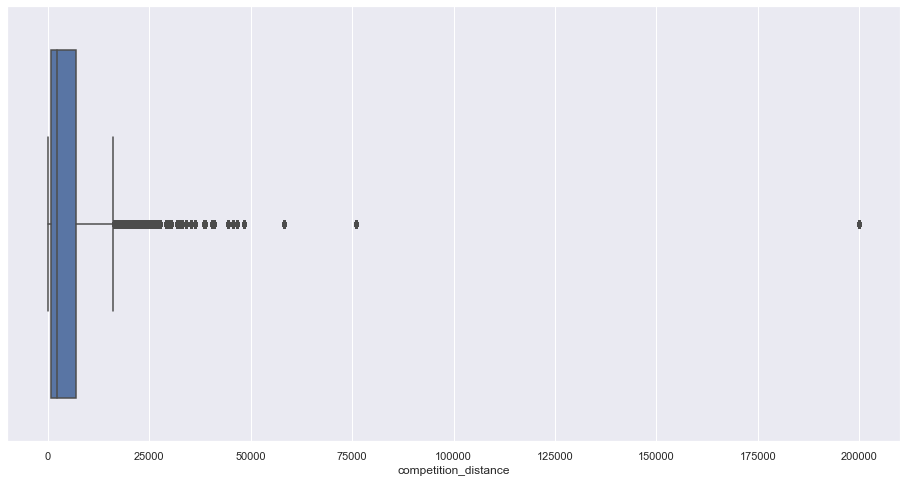

In [76]:
# Check competition_distance outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of competition_distance to check outliers
sns.boxplot( df5['competition_distance'] )

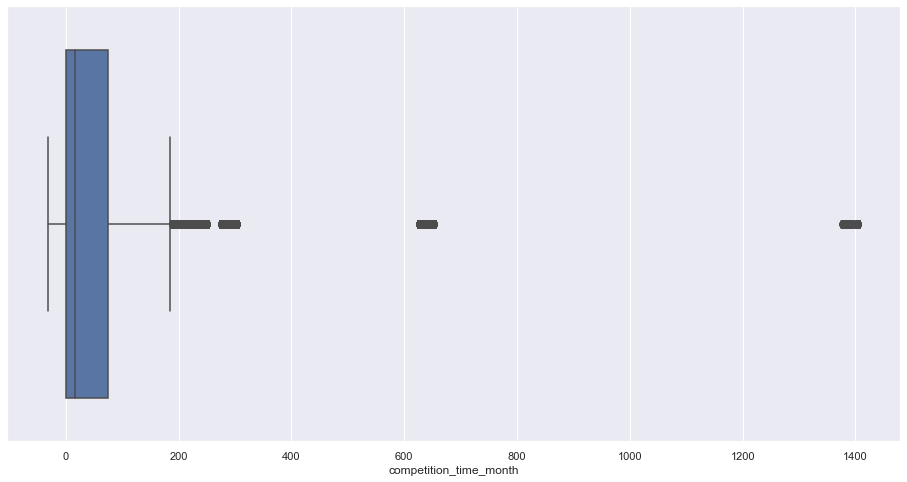

In [80]:
# Check competition_time_month outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of competition_time_month to check outliers
sns.boxplot( df5['competition_time_month'] )

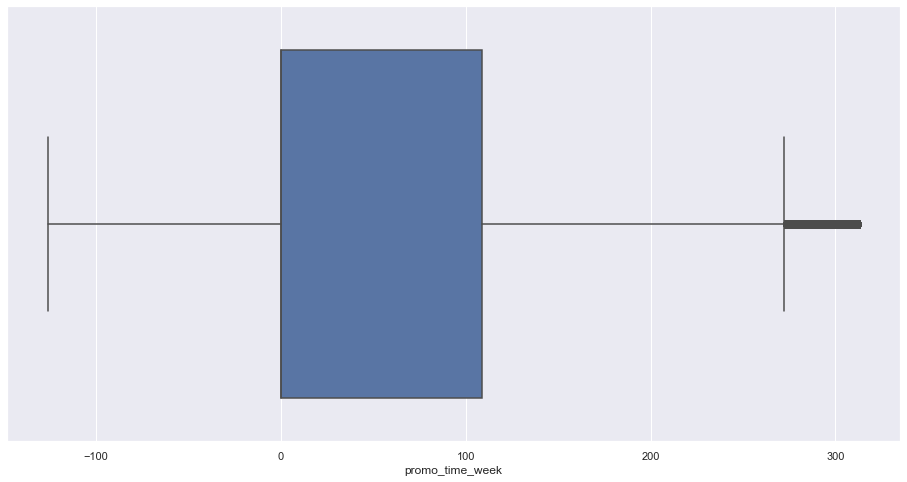

In [81]:
# Check promo_time_week outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of promo_time_week to check outliers
sns.boxplot( df5['promo_time_week'] )

In [83]:
# Rescaling application for numerical variables
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
# o fit_transform encontra o quartil 1 e quartil 3 e aplica na fórmula
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
# The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year - apply MinMaxScaler
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. Transformation

### 5.3.1. Encoding

In [85]:
# state_holiday - apply one-hot encoding with get_dummies from pandas
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - apply label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - apply ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [ ]:
# Tranformation application:
# month
# day
# week of year
# day of week